In [1]:
# modules importation
from trends_functions import *
import pickle
import os
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)

In [3]:
# computation parameters
params = get_params()

In [96]:
models = ['GEOS-i33p2_HIST', 'ECHAM6.3-HAM2.3-fSST_HIST']
od_vars = ['od550aer', 'od550dust', 'od550ss', 'od550so4', 'od550oa', 'od550bc']
emi_vars = ['emidust', 'emiss', 'emiso4', 'emioa', 'emibc']
varss = ['od550aer', 'od550dust', 'od550ss', 'od550so4', 'od550oa', 'od550bc', 'emidust', 'emiss', 'emiso4', 'emioa', 'emibc']

### compute 5x5 files for each species OD and EMI for some models

In [97]:
for var in varss:
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']

    mod_sources = params['models']
    

    resol = 5
    lons = np.arange(-180, 180, resol)
    lats = np.arange(-90, 90, resol)
    sample_points = [('latitude',lats), ('longitude', lons)]

    MOD_DATA = []
    for model in models:
        print(var,' - ',model)
        params['source'] = model

        #check if model in cache
        fn = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        if os.path.isfile(fn):
            # for reading also binary mode is important 
            pklfile = open(fn, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()
        else:
            reader = pya.io.ReadGridded(model)
            mod_data = reader.read_var(mod_var, ts_type='daily')
            mod_data = mod_data.resample_time(to_ts_type='monthly')
            mod_data = mod_data.interpolate(sample_points,scheme='nearest')

            #write picke file in cache directory
            pklfile = open(fn, 'ab') 

            # source, destination 
            pickle.dump(mod_data, pklfile)                      
            pklfile.close()

od550aer  -  GEOS-i33p2_HIST
od550aer  -  ECHAM6.3-HAM2.3-fSST_HIST
od550dust  -  GEOS-i33p2_HIST
od550dust  -  ECHAM6.3-HAM2.3-fSST_HIST
od550ss  -  GEOS-i33p2_HIST
od550ss  -  ECHAM6.3-HAM2.3-fSST_HIST
od550so4  -  GEOS-i33p2_HIST
od550so4  -  ECHAM6.3-HAM2.3-fSST_HIST
od550oa  -  GEOS-i33p2_HIST
od550oa  -  ECHAM6.3-HAM2.3-fSST_HIST
od550bc  -  GEOS-i33p2_HIST
od550bc  -  ECHAM6.3-HAM2.3-fSST_HIST
emidust  -  GEOS-i33p2_HIST
emidust  -  ECHAM6.3-HAM2.3-fSST_HIST
emiss  -  GEOS-i33p2_HIST
emiss  -  ECHAM6.3-HAM2.3-fSST_HIST
emiso4  -  GEOS-i33p2_HIST
emiso4  -  ECHAM6.3-HAM2.3-fSST_HIST
emioa  -  GEOS-i33p2_HIST
emioa  -  ECHAM6.3-HAM2.3-fSST_HIST
emibc  -  GEOS-i33p2_HIST
emibc  -  ECHAM6.3-HAM2.3-fSST_HIST


### compute trends for each variable

In [98]:
y1, y2 = 2000, 2014

In [99]:
TRENDS = {}

for var in varss:
    TRENDS[var] = {}
    
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']
    
    for model in models:
        #check if trend is in cache
        fn1 = 'cache/map_trend/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        
        if os.path.isfile(fn1):
            print(var,model,'use pickle',fn1)
            # for reading also binary mode is important 
            pklfile = open(fn1, 'rb')      
            TRENDS[var][model] = pickle.load(pklfile) 
            pklfile.close()
        else:
            print(var,model,'compute trend')
            fn0 = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
            # for reading also binary mode is important 
            pklfile = open(fn0, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()

            #average model data per year
            mod_data = mod_data.resample_time(to_ts_type='yearly')

            #initialize empty trends
            slopes = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            pvals = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))

            slopes[:] = np.nan
            pvals[:] = np.nan
            for ilat in np.arange((np.shape(mod_data)[1])):
                print(ilat,'/',np.shape(mod_data)[1], end="\r")
                for ilon in np.arange((np.shape(mod_data)[2])):
                    x = np.array([int(str(date)[0:4]) for date in mod_data.time_stamps()])
                    y = np.array(mod_data.data[:,ilat,ilon])

                    #get indexes within period
                    iok = [i for i, year in enumerate(x) if year>=y1 and year<=y2]
                    x = x[iok]
                    y = y[iok]

                    if len(x)>2:
                        trend = compute_lin_trend(x, y, params)
                        slopes[ilat, ilon] = trend[params['period']]['rel_slp']
                        pvals[ilat, ilon] = trend[params['period']]['pval']
            
            TRENDS[var][model] = slopes
            #writes pickle file
            pklfile = open(fn1, 'ab') 

            # source, destination 
            pickle.dump(slopes, pklfile)                      
            pklfile.close()

od550aer GEOS-i33p2_HIST use pickle cache/map_trend/GEOS-i33p2_HIST_od550aer-5x5.pkl
od550aer ECHAM6.3-HAM2.3-fSST_HIST use pickle cache/map_trend/ECHAM6.3-HAM2.3-fSST_HIST_od550aer-5x5.pkl
od550dust GEOS-i33p2_HIST use pickle cache/map_trend/GEOS-i33p2_HIST_od550dust-5x5.pkl
od550dust ECHAM6.3-HAM2.3-fSST_HIST use pickle cache/map_trend/ECHAM6.3-HAM2.3-fSST_HIST_od550dust-5x5.pkl
od550ss GEOS-i33p2_HIST use pickle cache/map_trend/GEOS-i33p2_HIST_od550ss-5x5.pkl
od550ss ECHAM6.3-HAM2.3-fSST_HIST use pickle cache/map_trend/ECHAM6.3-HAM2.3-fSST_HIST_od550ss-5x5.pkl
od550so4 GEOS-i33p2_HIST use pickle cache/map_trend/GEOS-i33p2_HIST_od550so4-5x5.pkl
od550so4 ECHAM6.3-HAM2.3-fSST_HIST use pickle cache/map_trend/ECHAM6.3-HAM2.3-fSST_HIST_od550so4-5x5.pkl
od550oa GEOS-i33p2_HIST use pickle cache/map_trend/GEOS-i33p2_HIST_od550oa-5x5.pkl
od550oa ECHAM6.3-HAM2.3-fSST_HIST use pickle cache/map_trend/ECHAM6.3-HAM2.3-fSST_HIST_od550oa-5x5.pkl
od550bc GEOS-i33p2_HIST use pickle cache/map_trend/GEO

### get also data for computing time series

In [100]:
DATA = {}
for var in varss:
    DATA[var] = {}
    
    #get models from params
    params = fill_params(params, var)

    for model in models:
        fn0 = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        # for reading also binary mode is important 
        pklfile = open(fn0, 'rb')      
        mod_data = pickle.load(pklfile) 
        pklfile.close()

        #average model data per year
        mod_data = mod_data.resample_time(to_ts_type='yearly')
        DATA[var][model] = mod_data

### make some statistics

In [102]:
#pick one color per species from palette
palette = sns.color_palette("deep", 18)

colors = {
    'od550aer': (0, 0, 0),
    'od550dust': palette[1],
    'od550ss': palette[0],
    'od550so4': palette[3],
    'od550oa': palette[2],
    'od550bc': palette[7],
    'emidust': palette[1],
    'emiss': palette[0],
    'emiso4': palette[3],
    'emioa': palette[2],
    'emibc': palette[7]
}

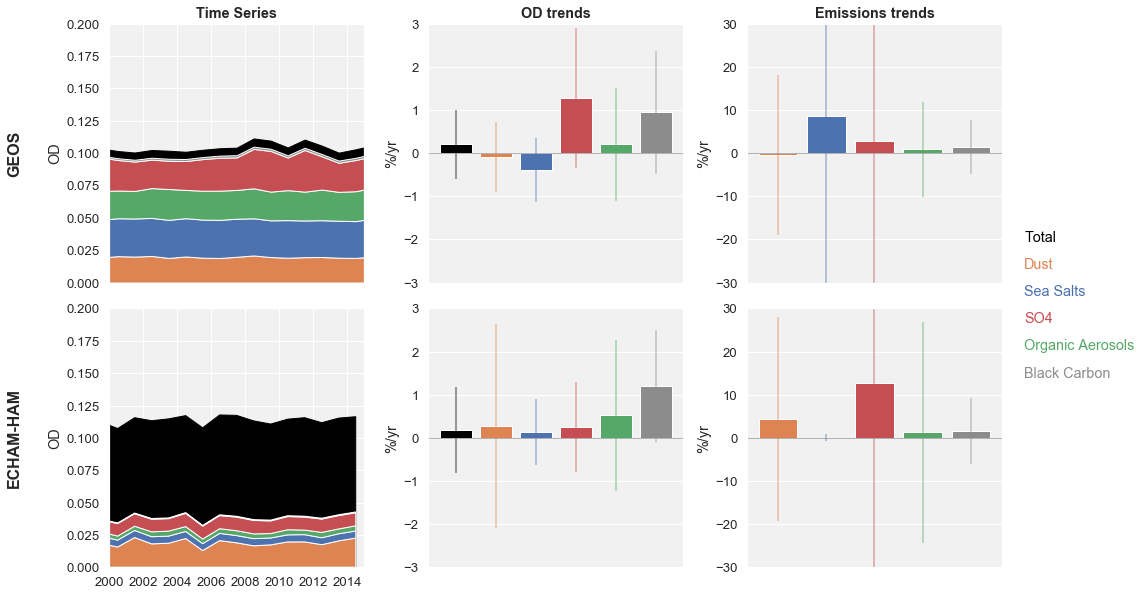

In [109]:
var = 'od550dust'

fs = 0.8
nl, nc = 2, 3
fig, axs = plt.subplots(nl, nc, sharex='col', sharey=False, 
                       gridspec_kw={
                           'wspace': 0.25,
                           'hspace': 0.1
                       })
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)

il, ic = 0, 0
for ic, typ in enumerate(['TS', 'OD', 'EMI']):
    for il, model in enumerate(models):
        ax = axs[il, ic]
        #setbackground color
        ax.set_facecolor('#F1F1F1')
        
        if typ=='TS':

            #set title
            if il==0:
                ax.set_title('Time Series', fontweight='bold')
                
            #plot time series

            #AOD
            var = 'od550aer'
            AOD = []
            time = DATA[var][model].time_stamps()
            for i in np.arange(np.shape(DATA[var][model].data)[0]):
                AOD.append(np.nanmean(DATA[var][model].data[i,:,:]))
            ax.stackplot(time, AOD, color=colors[var])

            #all species
            OD = []
            od_specs = ['od550dust', 'od550ss', 'od550oa', 'od550so4', 'od550bc']
            for var in od_specs:
                od = []
                for i in np.arange(np.shape(DATA[var][model].data)[0]):
                    od.append(np.nanmean(DATA[var][model].data[i,:,:]))
                OD.append(od)
            ax.stackplot(time, OD, colors=[colors[var] for var in od_specs])
            
            #set time series limits
            ax.set_xlim('2000-01-01','2015-01-01')
            ax.set_ylim(0,0.2)
        
            #set ylabel
            ax.set_ylabel('OD')
            
            #write model name
            ax.text(-0.4,0.5,get_all_mods()[model]['name'], rotation=90, fontweight='bold', va='center', fontsize=16, transform=ax.transAxes)
        
        if typ=='OD':
            #set title
            if il==0:
                ax.set_title('OD trends', fontweight='bold')
            
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            od_bars, od_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(od_vars):
                od_bars.append(np.nanmean(TRENDS[var][model]))
                od_errs.append(np.nanstd(TRENDS[var][model]))
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(od_bars)), od_bars, yerr=od_errs, color=cols, ecolor=ecols, edgecolor='white')
            
            #set axis
            ax.set_ylim(-3,3)
            
            #set ylabel
            ax.set_ylabel('%/yr')
            ax.set_xticks([])
            
            
        elif typ=='EMI':
            #set title
            if il==0:
                ax.set_title('Emissions trends', fontweight='bold')
                
            #plot a horizontal line at the zero value
            ax.axhline(y=0, ls='-', lw=1, color=(.5, .5, .5), alpha=.6)
        
            #prepare arrays to be plotted
            emi_bars, emi_errs, cols, ecols = [], [], [], []
            for i, var in enumerate(emi_vars):
                emi_bars.append(np.nanmean(TRENDS[var][model]))
                emi_errs.append(np.nanstd(TRENDS[var][model]))
                cols.append((*colors[var],1))
                ecols.append((*colors[var],0.5))
                
            #plot bars
            ax.bar(np.arange(0,len(emi_bars)), emi_bars, yerr=emi_errs, color=cols, ecolor=ecols, edgecolor='white')
            
            
        
            #set axis
            ax.set_ylim(-30,30)
            
            #set ylabel
            ax.set_ylabel('%/yr')
            ax.set_xticks([])

            
        
        il+=1
        if il>=nl:
            il, ic= 0, ic+1


#change size of the figure
# hide tick and tick label of the big axes
plt.tick_params(labelcolor=None, top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Put a legend to the right of the current axis
dy = 0.05
for i, var in enumerate(od_vars):
    if 'aer' in var:
        txt = 'Total'
    elif 'dust' in var:
        txt = 'Dust'
    elif 'ss' in var:
        txt = 'Sea Salts'
    elif 'oa' in var:
        txt = 'Organic Aerosols'
    elif 'so4' in var:
        txt = 'SO4'
    elif 'bc' in var:
        txt = 'Black Carbon'
    
        
    plt.text(1.025,0.6-dy*i, txt, color=colors[var], ha='left')

fx = 1.0
fig.set_size_inches(16*fx,10*fx)
plt.savefig('figs/species_trends.png', dpi=300, bbox_inches='tight')